In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [11]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

#X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
#Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))

X_motion_CoM = X_motion_CoM_continuous
Y_motion_CoM = Y_motion_CoM_continuous

print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(704, 24)
(704, 3)


# Multivariate Linear Regression (CoM Prediction)

In [12]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [13]:
X_motion_CoM.shape

(704, 24)

In [14]:
idx_fr_rl_swinging = np.where(X_motion_CoM[:, -1] == 1)[0]
X_motion_CoM_FR_RL = X_motion_CoM[idx_fr_rl_swinging]
Y_motion_CoM_FR_RL = Y_motion_CoM[idx_fr_rl_swinging]
print(X_motion_CoM_FR_RL.shape)
print(Y_motion_CoM_FR_RL.shape)

(349, 24)
(349, 3)


## Predict CoM (x) movement

In [15]:
X_motion_CoM_FR_RL[0, :3]

array([0.1, 0. , 0. ])

In [16]:
Y_motion_CoM_FR_RL[0, :]

array([ 0.02679094,  0.00238138, -0.00387229])

### Linear Regression

In [17]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, 3:6], # Current motion command
               X_motion_CoM_FR_RL[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FR_RL[:, 6:8], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 15:17])) # RR (x, y) position
               
# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9868382117188506
RMSE:  0.006456980416447172
The lowest error is:  2.93270025432113e-05
The highest error is:  0.020522490418911188
The avg. error is:  0.00447774142091578


In [18]:
model_fr_com_x.coef_

array([[-2.84671655e-02, -2.49800181e-16, -1.38777878e-17,
         5.88217476e-02, -1.94289029e-16,  2.91433544e-16,
         2.22999889e-01, -2.32281918e-01,  7.66594336e-01,
        -6.94219467e-01, -2.83934670e-01,  2.23062379e-01,
        -3.67990303e-02, -2.41687131e-01, -8.77510869e-01,
         3.32153815e-01]])

In [19]:
model_fr_com_x.intercept_

array([-0.15848303])

In [20]:
#input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0, 0.237936324231, 0.188065700274, 0.234281409653, -0.171743092874, -0.249921495098, 0.161507381121, -0.259071586366, -0.138188475913]])
#output = input_ @ model_fr_com_x.coef_.T + model_fr_com_x.intercept_
#print(output)

Text(0, 0.5, 'Predictions')

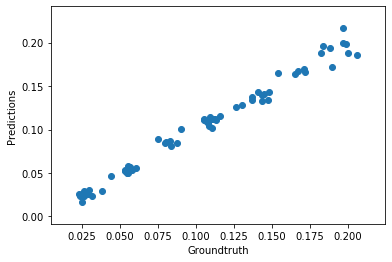

In [21]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [21]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

## Predict CoM -> y

### Linear Regression

In [23]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, 3:6], # Current motion command
               X_motion_CoM_FR_RL[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FR_RL[:, 6:8], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.42262377735468204
RMSE:  0.0023133490347812162
The lowest error is:  3.182464140492891e-05
The highest error is:  0.005856814327663919
The avg. error is:  0.0018308549283013473


In [24]:
model_fr_com_y.coef_

array([[ 1.67006987e-04,  2.24646690e-16, -3.46944695e-18,
         1.14214733e-02,  5.55111512e-17,  2.77555756e-17,
        -3.62313152e-02,  5.79267150e-02,  1.29445306e-03,
         1.56508893e-01, -6.23460752e-02, -2.60236183e-01,
        -2.26357676e-02, -6.80489026e-02,  1.56029888e-01,
         2.89861444e-01]])

In [25]:
model_fr_com_y.intercept_

array([0.0413813])

Text(0, 0.5, 'Predictions')

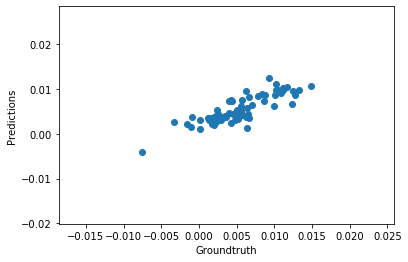

In [26]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [27]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

## Predict CoM -> Yaw

In [29]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, 3:6], # Current motion command
               X_motion_CoM_FR_RL[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FR_RL[:, 6:8], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -1.595551772384308
RMSE:  0.0019056860177515552
The lowest error is:  2.6533050382306425e-05
The highest error is:  0.00669479377532484
The avg. error is:  0.001465380952665922


In [30]:
model_fl_com_theta.coef_

array([[-2.04539987e-04, -1.04083409e-17, -1.17093835e-17,
         4.31520933e-04,  2.08166817e-17,  0.00000000e+00,
         1.41718282e-02, -3.69755264e-03, -2.32710590e-02,
        -1.35728481e-02, -4.45949869e-02, -9.42437272e-02,
         6.23856636e-03, -1.27494556e-03, -6.41112269e-02,
         3.14188803e-02]])

In [31]:
model_fl_com_theta.intercept_

array([-0.00685261])

Text(0, 0.5, 'Predictions')

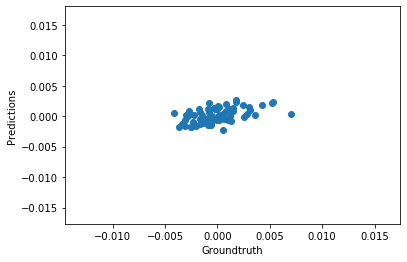

In [32]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")